In [52]:
import pandas as pd
import pm4py

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter



log = xes_importer.apply("../data/BPIC2017.xes.gz")


df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
if "lifecycle:transition" in df.columns:
    df = df[df["lifecycle:transition"].eq("complete")]



parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

## 3.3 Process Model Creation and Validation

### Inductive Miner
As a first discovery algorithm, the Inductive Miner is applied.
It is designed to produce sound Petri nets with a block-structured shape,
which usually leads to models that are easier to interpret

In [71]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_viz


pt_ind = inductive_miner.apply(df)


net_ind, im_ind, fm_ind = pt_converter.apply(pt_ind)


gviz_ind = pn_viz.apply(net_ind, im_ind, fm_ind, parameters={"format": "png", "dpi": 300})


pn_viz.save(gviz_ind, "inductive.png")

''

The Petri net discovered by the Inductive Miner contains a large number of black transitions, which represent silent transitions (τ-transitions). These transitions do not correspond to real activities in the log but are automatically inserted by the miner to model routing behavior such as parallel splits, merges, optional paths and loops. Since the BPIC17 process contains many variants and complex control-flow patterns, the miner introduces a considerable number of silent transitions to ensure that the model is sound and able to replay all traces. As a result, the Petri net becomes very detailed and visually hard to interpret, even though it is semantically correct.

For interpretation purposes, the process tree discovered by the Inductive Miner is more suitable, because it shows the same control-flow structure in a compact and human-readable way without internal routing elements.

### Process Tree

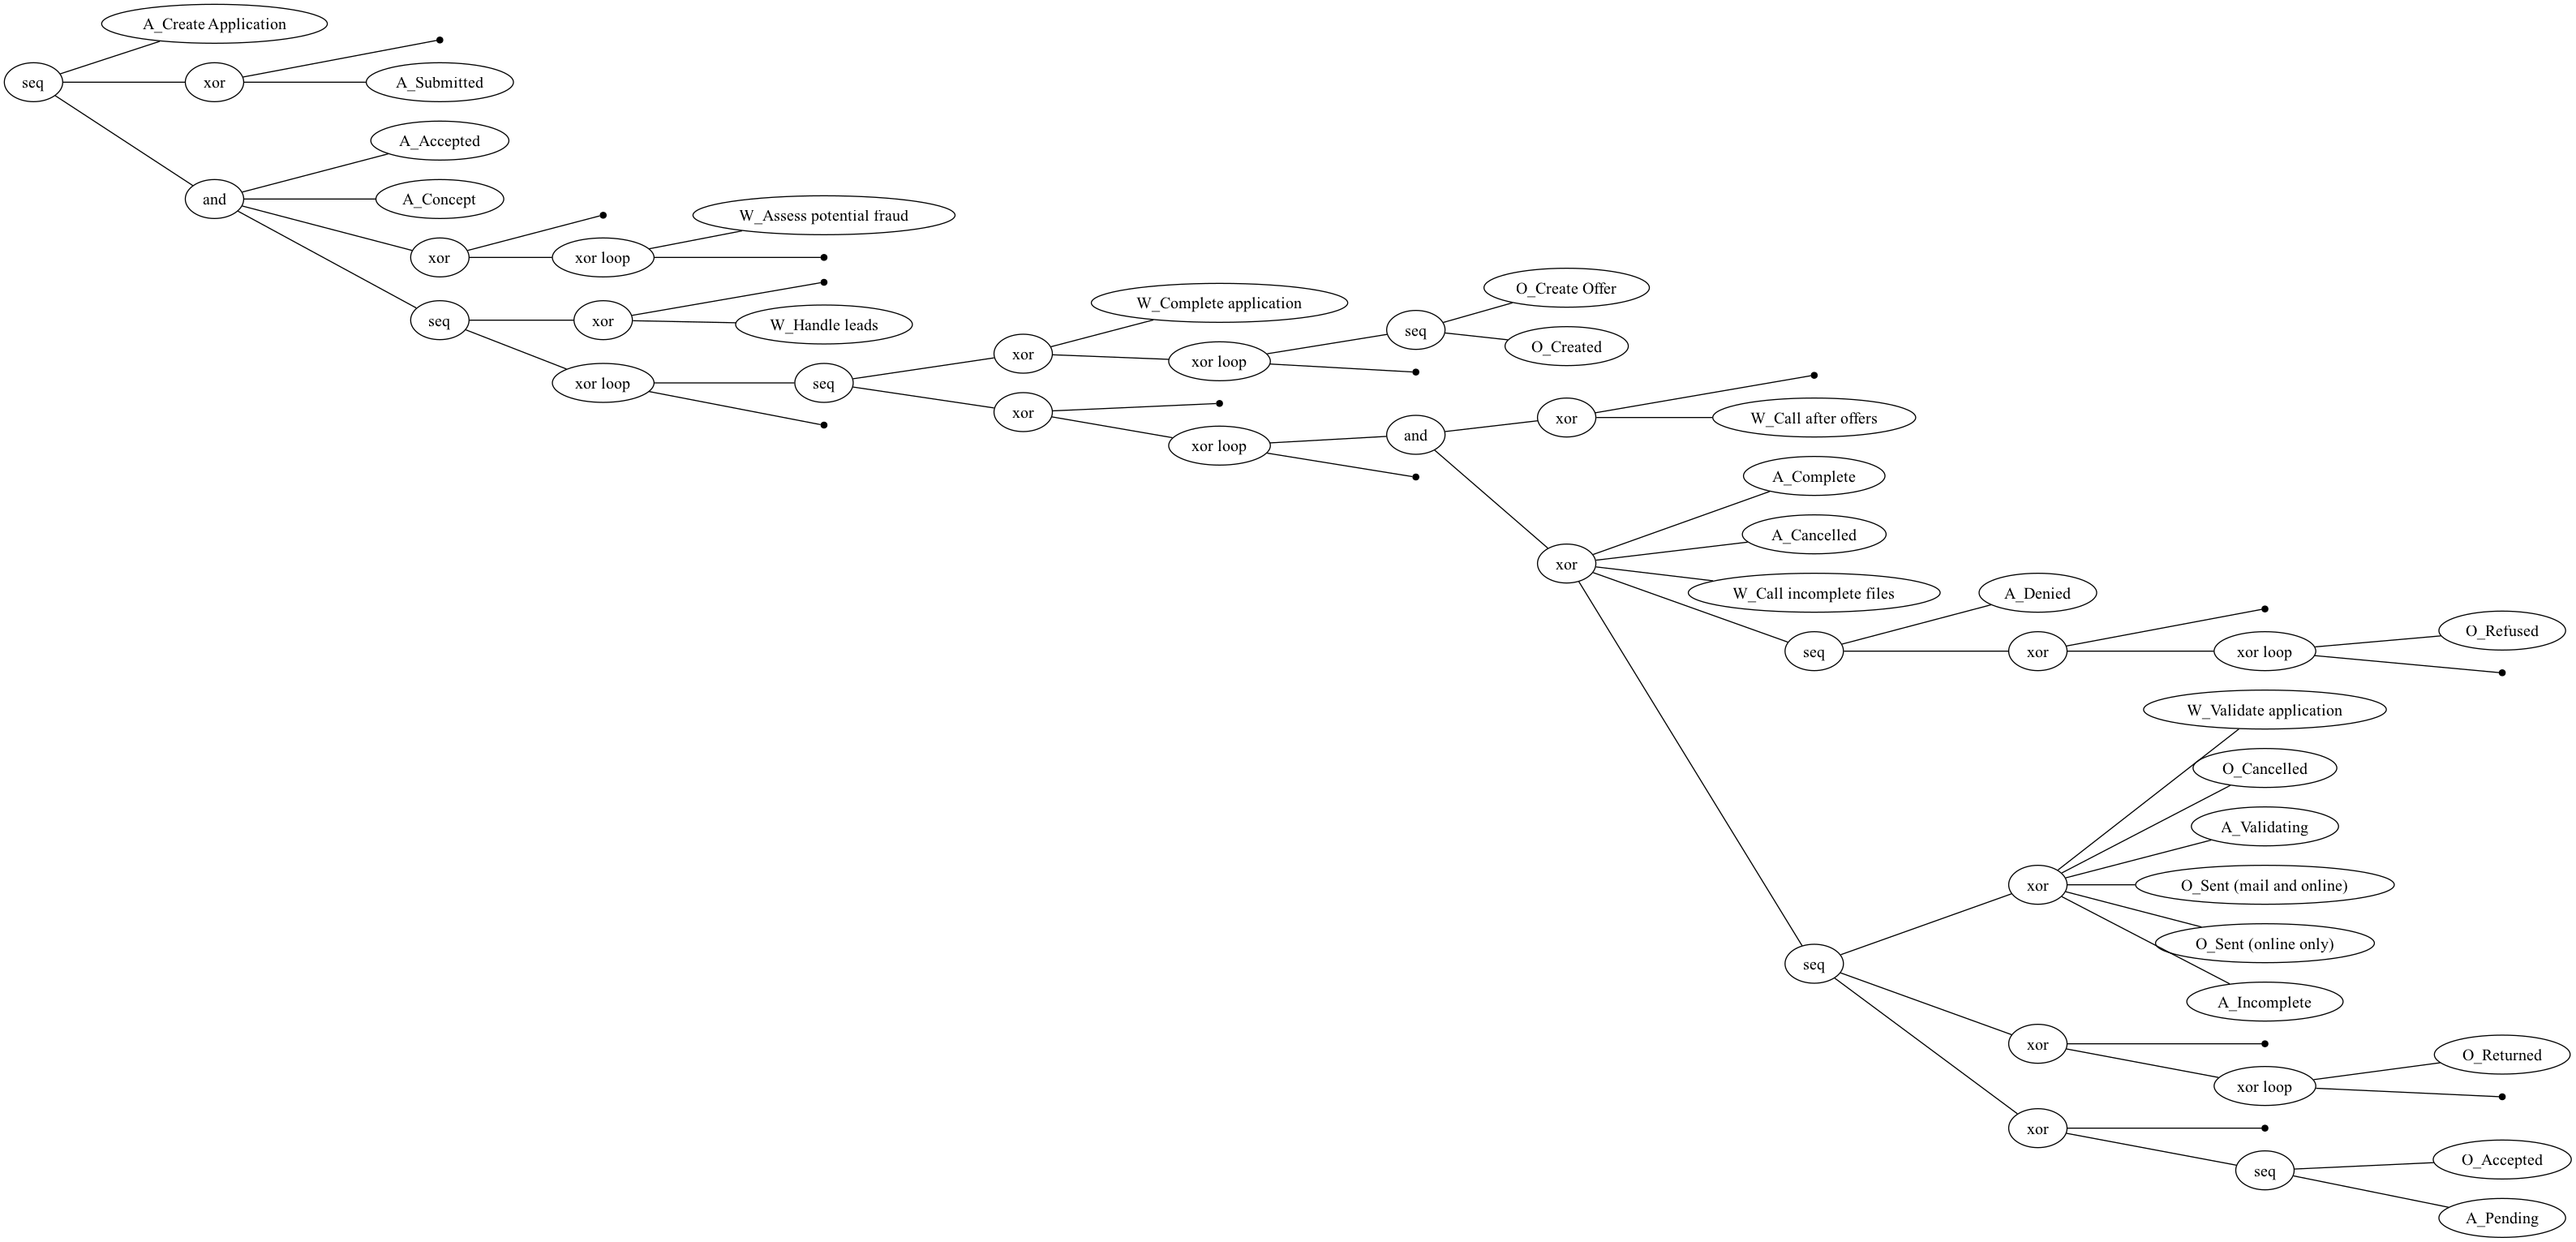

In [72]:
from pm4py.visualization.process_tree import visualizer as pt_viz

pt_ind = inductive_miner.apply(df)
gviz_tree = pt_viz.apply(pt_ind)
pt_viz.view(gviz_tree)

### Heuristics Miner

In [73]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_viz
from pm4py.objects.conversion.heuristics_net import converter as hn_converter

parameters = {
    "dependency_threshold": 0.99,
    "min_act_freq": 1000,
    "min_dfg_occurrences": 1000
}

heu_net = heuristics_miner.apply_heu(df, parameters=parameters)


gviz_hn = hn_viz.apply(heu_net)
hn_viz.save(gviz_hn, "heuristics.png")
net_heu, im_heu, fm_heu = hn_converter.apply(heu_net)

### Alpha Miner

In [74]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner


net_alpha, im_alpha, fm_alpha = alpha_miner.apply(df)

gviz_alpha = pn_viz.apply(net_alpha, im_alpha, fm_alpha)

pn_viz.save(gviz_alpha, "alpha.png")



''

### Metrics

### Fitness 

In [75]:
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator

fitness_ind = fitness_evaluator.apply(df, net_ind, im_ind, fm_ind, variant=fitness_evaluator.Variants.TOKEN_BASED)
fitness_heu = fitness_evaluator.apply(df, net_heu, im_heu, fm_heu, variant=fitness_evaluator.Variants.TOKEN_BASED)
fitness_alpha = fitness_evaluator.apply(df, net_alpha, im_alpha, fm_alpha, variant=fitness_evaluator.Variants.TOKEN_BASED)
fitness_ind, fitness_heu, fitness_alpha

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

({'perc_fit_traces': 100.0,
  'average_trace_fitness': 1.0,
  'log_fitness': 1.0,
  'percentage_of_fitting_traces': 100.0},
 {'perc_fit_traces': 0.0,
  'average_trace_fitness': 0.8365203874260899,
  'log_fitness': 0.841759926737069,
  'percentage_of_fitting_traces': 0.0},
 {'perc_fit_traces': 0.0,
  'average_trace_fitness': 0.5001117298882956,
  'log_fitness': 0.495774473479623,
  'percentage_of_fitting_traces': 0.0})

### Precision


precision_heu = precision_evaluator.apply(df, net_heu, im_heu, fm_heu, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)

In [78]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator

precision_ind = precision_evaluator.apply(df, net_ind, im_ind, fm_ind, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
precision_heu = precision_evaluator.apply(df, net_heu, im_heu, fm_heu, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
precision_alpha = precision_evaluator.apply(df, net_alpha, im_alpha, fm_alpha, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
precision_ind, precision_heu, precision_alpha

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

(0.2926135820916598, 0.9998315564186913, 0.12590195124851544)

### Generalization

In [80]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

generalization_ind   = generalization_evaluator.apply(df, net_ind,  im_ind,  fm_ind)
generalization_heu   = generalization_evaluator.apply(df, net_heu, im_heu, fm_heu)
generalization_alpha = generalization_evaluator.apply(df, net_alpha, im_alpha, fm_alpha)
generalization_ind, generalization_heu, generalization_alpha

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

(0.9756702764431168, 0.898749138306055, 0.9869939686795314)

### Simplicity

In [81]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

simplicity_ind   = simplicity_evaluator.apply(net_ind)
simplicity_heu   = simplicity_evaluator.apply(net_heu)
simplicity_alpha = simplicity_evaluator.apply(net_alpha)
simplicity_ind, simplicity_heu, simplicity_alpha

(0.6170212765957447, 0.5584415584415584, 0.392)

### Table with all metrics

In [82]:
metrics_df = pd.DataFrame([
    {
        "Model": "Alpha Miner",
        "Fitness": fitness_alpha["log_fitness"],
        "Precision": precision_alpha,
        "Generalization": generalization_alpha,
        "Simplicity": simplicity_alpha
    },
    {
        "Model": "Inductive Miner",
        "Fitness": fitness_ind["log_fitness"],
        "Precision": precision_ind,
        "Generalization": generalization_ind,
        "Simplicity": simplicity_ind
    },
    {
        "Model": "Heuristics Miner",
        "Fitness": fitness_heu["log_fitness"],
        "Precision": precision_heu,
        "Generalization": generalization_heu,
        "Simplicity": simplicity_heu
    }
])

metrics_df

,Model,Fitness,Precision,Generalization,Simplicity
0,Alpha Miner,0.495774,0.125902,0.986994,0.392000
1,Inductive Miner,1.000000,0.292614,0.975670,0.617021
2,Heuristics Miner,0.841760,0.999832,0.898749,0.558442


### Additional Metrics
### Structural Size (Number of Nodes).
This metric counts the total number of places and transitions in a Petri net. A smaller model naturally contains fewer control-flow elements and is therefore easier to understand and maintain. This metric directly reflects the structural footprint of the model and allows straightforward comparison between models.

In [19]:
def simplicity_size(net):
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    size = num_places + num_transitions
    return {
        "places": num_places,
        "transitions": num_transitions,
        "size_total": size
    }

In [20]:
simp1 = simplicity_size(net_ind)
simp1

{'places': 55, 'transitions': 87, 'size_total': 142}

### Connectivity
While the size metric captures how large a model is, it does not show how tightly connected the model is. Therefore, I added connectivity, defined as the ratio between the actual number of arcs and the theoretical maximum number of arcs for a model of the same size. Lower values indicate fewer cross-connections and therefore a simpler, cleaner structure.


In [21]:
def simplicity_arc_density(net):
    num_arcs = len(net.arcs)
    num_nodes = len(net.places) + len(net.transitions)

    if num_nodes <= 1:
        return 0

    max_possible_arcs = num_nodes * (num_nodes - 1)
    density = num_arcs / max_possible_arcs
    return {
        "arcs": num_arcs,
        "nodes": num_nodes,
        "density": density
    }

In [22]:
simp2 = simplicity_arc_density(net_ind)
simp2

{'arcs': 184, 'nodes': 142, 'arc_density': 0.009189891119768255}